<a href="https://colab.research.google.com/github/Mu-niu13/AIPI-590-HWs/blob/main/Human-AI%20Interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Human-AI Interaction

### Mu Niu

Claude Sonnet 4.5 is used to help with coding

# Shapley Value Tutorial: A Complete Guide with Code

## Table of Contents
1. [Introduction](#scrollTo=TnRXSZCXlXl_&line=18&uniqifier=1)
2. [Mathematical Foundation](#scrollTo=m5pVT3xJl-o1&line=22&uniqifier=1)
3. [Simple Example: Pizza Delivery](#scrollTo=xd4-K1hLmVfc&line=116&uniqifier=1)
4. [Implementation from Scratch](#scrollTo=MJf7RxNMmuLd&line=153&uniqifier=1)
5. [Machine Learning Application](#scrollTo=JQB91oCXohKh&line=5&uniqifier=1n)
6. [Advanced Topics](#scrollTo=T-3vx4FooJKT&line=72&uniqifier=1)
7. [Summary](#scrollTo=VDoA49ssqls5&line=8&uniqifier=1)

## Introduction

### What are Shapley Values?

**Shapley Values** are a concept from cooperative game theory that fairly distributes the "payout" among players based on their individual contributions to the total payout. Named after Lloyd Shapley (Nobel Prize, 2012), they answer: *"How much did each player contribute to the outcome?"*

### Key Properties

1. **Efficiency**: All contributions sum to the total value
2. **Symmetry**: Players with equal contributions get equal shares
3. **Dummy**: Players with no contribution get zero
4. **Additivity**: Values are additive across games

### Applications

- **Machine Learning**: Feature importance (SHAP values)
- **Economics**: Fair cost/profit allocation
- **Data Valuation**: Determining data point importance

## Mathematical Foundation

### The Formula

For a player *i* in a game with players *N*, the Shapley value φᵢ is:

```
φᵢ(v) = Σ [|S|! × (|N| - |S| - 1)! / |N|!] × [v(S ∪ {i}) - v(S)]
```

Where:
- *S* ranges over all subsets of *N* not containing *i*
- *v(S)* is the value function for coalition *S*
- The term in brackets is the weight

### Intuition

For each player, we calculate:
1. Consider all possible coalitions without that player
2. Add the player and measure the marginal contribution
3. Weight by the probability of that coalition forming
4. Average across all coalitions

## Simple Example: Pizza Delivery

Let's say three friends (Alice, Bob, Carol) order pizza together. The delivery fee depends on how many people split it.

```python
import itertools
from typing import Dict, Set, Callable, List

def pizza_delivery_value(coalition: Set[str]) -> float:
    """
    Value function: Base cost $10, but discount for groups.
    - Empty coalition: $0
    - 1 person: $10
    - 2 people: $16 (not $20, there's a discount)
    - 3 people: $21 (better discount)
    """
    size = len(coalition)
    if size == 0:
        return 0
    elif size == 1:
        return 10
    elif size == 2:
        return 16
    else:  # size == 3
        return 21

# Define players
players = {'Alice', 'Bob', 'Carol'}

def calculate_shapley_value(
    player: str,
    all_players: Set[str],
    value_func: Callable[[Set[str]], float]
) -> float:
    """
    Calculate Shapley value for a single player.
    
    Args:
        player: The player to calculate value for
        all_players: Set of all players in the game
        value_func: Function that returns value for any coalition
    
    Returns:
        The Shapley value for the player
    """
    shapley = 0.0
    n = len(all_players)
    
    # Get all players except the current one
    others = all_players - {player}
    
    # Iterate through all possible coalitions without this player
    for r in range(len(others) + 1):
        for coalition in itertools.combinations(others, r):
            coalition_set = set(coalition)
            
            # Marginal contribution: value with player - value without player
            with_player = value_func(coalition_set | {player})
            without_player = value_func(coalition_set)
            marginal_contribution = with_player - without_player
            
            # Weight: probability of this coalition forming
            coalition_size = len(coalition_set)
            weight = (
                factorial(coalition_size) *
                factorial(n - coalition_size - 1) /
                factorial(n)
            )
            
            shapley += weight * marginal_contribution
    
    return shapley

def factorial(n: int) -> int:
    """Calculate factorial."""
    if n <= 1:
        return 1
    result = 1
    for i in range(2, n + 1):
        result *= i
    return result

# Calculate Shapley values for all players
print("Pizza Delivery Example")
print("=" * 50)
print(f"Total cost with all 3 people: ${pizza_delivery_value(players)}")
print()

for player in players:
    shapley = calculate_shapley_value(player, players, pizza_delivery_value)
    print(f"{player}'s fair share: ${shapley:.2f}")

# Verify efficiency property
total_shapley = sum(
    calculate_shapley_value(p, players, pizza_delivery_value)
    for p in players
)
print(f"\nSum of all shares: ${total_shapley:.2f}")
print(f"Total cost: ${pizza_delivery_value(players):.2f}")
print(f"Difference: ${abs(total_shapley - pizza_delivery_value(players)):.6f}")
```

### Expected Output:
```
Pizza Delivery Example
==================================================
Total cost with all 3 people: $21

Alice's fair share: $7.00
Bob's fair share: $7.00
Carol's fair share: $7.00

Sum of all shares: $21.00
Total cost: $21.00
Difference: 0.000000
```

## Implementation from Scratch

Here's a complete, reusable implementation:

```python
from typing import Set, Callable, Dict, List, Any
import itertools

class ShapleyCalculator:
    """
    A general-purpose Shapley value calculator.
    
    This class can compute Shapley values for any cooperative game
    defined by a value function.
    """
    
    def __init__(self, players: Set[Any], value_function: Callable[[Set[Any]], float]):
        """
        Initialize the calculator.
        
        Args:
            players: Set of all players in the game
            value_function: Function mapping coalitions to their value
        """
        self.players = players
        self.value_function = value_function
        self.n = len(players)
        
    def marginal_contribution(
        self,
        player: Any,
        coalition: Set[Any]
    ) -> float:
        """
        Calculate marginal contribution of a player to a coalition.
        
        Args:
            player: The player being added
            coalition: The existing coalition (without player)
        
        Returns:
            The marginal contribution
        """
        with_player = self.value_function(coalition | {player})
        without_player = self.value_function(coalition)
        return with_player - without_player
    
    def coalition_weight(self, coalition_size: int) -> float:
        """
        Calculate the weight for a coalition of given size.
        
        Args:
            coalition_size: Number of players in coalition (excluding target player)
        
        Returns:
            The weight (probability factor)
        """
        s = coalition_size
        n = self.n
        
        numerator = self._factorial(s) * self._factorial(n - s - 1)
        denominator = self._factorial(n)
        
        return numerator / denominator
    
    def _factorial(self, n: int) -> int:
        """Calculate factorial."""
        if n <= 1:
            return 1
        result = 1
        for i in range(2, n + 1):
            result *= i
        return result
    
    def shapley_value(self, player: Any) -> float:
        """
        Calculate Shapley value for a single player.
        
        Args:
            player: The player to calculate value for
        
        Returns:
            The Shapley value
        """
        shapley = 0.0
        others = self.players - {player}
        
        # Iterate through all possible coalition sizes
        for r in range(len(others) + 1):
            # Get all coalitions of size r
            for coalition in itertools.combinations(others, r):
                coalition_set = set(coalition)
                
                # Calculate weighted marginal contribution
                mc = self.marginal_contribution(player, coalition_set)
                weight = self.coalition_weight(len(coalition_set))
                
                shapley += weight * mc
        
        return shapley
    
    def all_shapley_values(self) -> Dict[Any, float]:
        """
        Calculate Shapley values for all players.
        
        Returns:
            Dictionary mapping players to their Shapley values
        """
        return {player: self.shapley_value(player) for player in self.players}
    
    def verify_efficiency(self) -> bool:
        """
        Verify that Shapley values sum to total game value.
        
        Returns:
            True if efficiency property holds (within floating point precision)
        """
        total_shapley = sum(self.all_shapley_values().values())
        total_value = self.value_function(self.players)
        
        return abs(total_shapley - total_value) < 1e-9


# Example: Three-person game
def custom_value_function(coalition: Set[int]) -> float:
    """
    Custom value function for demonstration.
    Returns: sum of player numbers squared if coalition has 2+ players,
             otherwise sum of player numbers.
    """
    if len(coalition) == 0:
        return 0
    elif len(coalition) == 1:
        return sum(coalition)
    else:
        return sum(x**2 for x in coalition)

# Calculate Shapley values
players = {1, 2, 3}
calculator = ShapleyCalculator(players, custom_value_function)

print("Custom Game Example")
print("=" * 50)
print(f"Players: {players}")
print(f"Total value: {custom_value_function(players)}")
print()

shapley_values = calculator.all_shapley_values()
for player, value in sorted(shapley_values.items()):
    print(f"Player {player}: {value:.4f}")

print(f"\nEfficiency verified: {calculator.verify_efficiency()}")
```

## Machine Learning Application

Shapley values are widely used in ML for explaining model predictions through the **SHAP** library (SHapley Additive exPlanations).

### Installation

In [ ]:
pip install shap scikit-learn pandas matplotlib

### Example 1: Linear Model with SHAP

In [ ]:
import shap
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Create synthetic dataset
np.random.seed(42)
n_samples = 100

# Generate features
X = pd.DataFrame({
    'square_feet': np.random.randint(800, 3000, n_samples),
    'bedrooms': np.random.randint(1, 6, n_samples),
    'age_years': np.random.randint(0, 50, n_samples),
    'distance_to_city': np.random.randint(1, 30, n_samples)
})

# Generate target (house prices) with known relationships
y = (
    150 * X['square_feet'] +
    20000 * X['bedrooms'] -
    500 * X['age_years'] -
    1000 * X['distance_to_city'] +
    np.random.normal(0, 10000, n_samples)
)

# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

print("Machine Learning Example: House Price Prediction")
print("=" * 60)
print(f"Model R² Score: {model.score(X_test, y_test):.4f}")
print()

# Create SHAP explainer
# For linear models, use LinearExplainer (exact Shapley values)
explainer = shap.LinearExplainer(model, X_train)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Explain a single prediction
instance_idx = 0
instance = X_test.iloc[instance_idx]
prediction = model.predict(instance.values.reshape(1, -1))[0]
base_value = explainer.expected_value

print(f"Explaining prediction for house #{instance_idx}")
print("-" * 60)
print(f"Predicted price: ${prediction:,.2f}")
print(f"Base value (average): ${base_value:,.2f}")
print()

# Show SHAP values for each feature
print("Feature contributions (SHAP values):")
for feature_name, feature_value, shap_value in zip(X.columns, instance, shap_values[instance_idx]):
    print(f"  {feature_name:20s}: {feature_value:8.1f} → SHAP = ${shap_value:10,.2f}")

print()
print(f"Sum of SHAP values: ${shap_values[instance_idx].sum():,.2f}")
print(f"Prediction - Base: ${prediction - base_value:,.2f}")
print()

# Verify efficiency property (sum of SHAP values = prediction - base_value)
assert np.abs(shap_values[instance_idx].sum() - (prediction - base_value)) < 1e-6
print("✓ Efficiency property verified!")

Machine Learning Example: House Price Prediction
Model R² Score: 0.9894

Explaining prediction for house #0
------------------------------------------------------------
Predicted price: $377,166.41
Base value (average): $306,926.62

Feature contributions (SHAP values):
  square_feet         :   2663.0 → SHAP = $124,647.43
  bedrooms            :      1.0 → SHAP = $-40,289.08
  age_years           :     33.0 → SHAP = $ -3,966.39
  distance_to_city    :     26.0 → SHAP = $-10,152.16

Sum of SHAP values: $70,239.79
Prediction - Base: $70,239.79

✓ Efficiency property verified!


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Example 2: Tree-Based Model (Random Forest)

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import shap

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)

print("\n" + "=" * 60)
print("Random Forest Model with Tree SHAP")
print("=" * 60)
print(f"Model R² Score: {rf_model.score(X_test, y_test):.4f}\n")

# Create Tree SHAP explainer (efficient for tree models)
explainer_rf = shap.TreeExplainer(rf_model)

# --- Compute SHAP values (compatible with older/newer SHAP) ---
try:
    # Newer API
    exp = explainer_rf(X_test)
    shap_values_rf = exp.values                    # (n_samples, n_features)
    base_values = exp.base_values                  # (n_samples,) or scalar
except TypeError:
    # Older API
    shap_values_rf = explainer_rf.shap_values(X_test)
    # expected_value may be scalar or array-like; standardize to per-row
    ev = explainer_rf.expected_value
    # Make base_values a vector matching the number of rows
    base_values = np.repeat(ev, len(X_test)) if np.isscalar(ev) else np.full(len(X_test), np.array(ev).reshape(-1)[0])

# Pick an instance to explain
instance_idx = 0
x_row = X_test.iloc[instance_idx:instance_idx+1]
prediction_rf = rf_model.predict(x_row)[0]
base_value_rf = float(np.array(base_values).reshape(-1)[instance_idx])

print(f"Explaining prediction for row #{instance_idx}")
print("-" * 60)
print(f"Predicted value: {prediction_rf:,.2f}")
print(f"Base value (expected): {base_value_rf:,.2f}\n")

if isinstance(shap_values_rf, list):
    shap_vals_instance = np.array(shap_values_rf[0])[instance_idx]
else:
    shap_vals_instance = shap_values_rf[instance_idx]

# Print feature contributions (robust to non-numeric displays)
print("Feature contributions (SHAP values):")
for feat_name, feat_val, shap_val in zip(X_test.columns, X_test.iloc[instance_idx], shap_vals_instance):
    try:
        feat_val_str = f"{float(feat_val):.3f}"
    except Exception:
        feat_val_str = str(feat_val)
    print(f"  {feat_name:20s}: {feat_val_str:>12}  →  SHAP = {shap_val:>12,.4f}")

sum_shap = float(np.sum(shap_vals_instance))
print("\n" + "-" * 60)
print(f"Sum of SHAP values:    {sum_shap:,.4f}")
print(f"Prediction - Base:     {prediction_rf - base_value_rf:,.4f}")


Random Forest Model with Tree SHAP
Model R² Score: 0.9229

Explaining prediction for row #0
------------------------------------------------------------
Predicted value: 425,219.80
Base value (expected): 307,702.73

Feature contributions (SHAP values):
  square_feet         :     2663.000  →  SHAP = 138,928.9061
  bedrooms            :        1.000  →  SHAP = -16,845.9387
  age_years           :       33.000  →  SHAP =  -1,681.7900
  distance_to_city    :       26.000  →  SHAP =  -2,884.1047

------------------------------------------------------------
Sum of SHAP values:    117,517.0727
Prediction - Base:     117,517.0727


### Example 3: Visualizations

/tmp/ipython-input-2164813441.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_test)


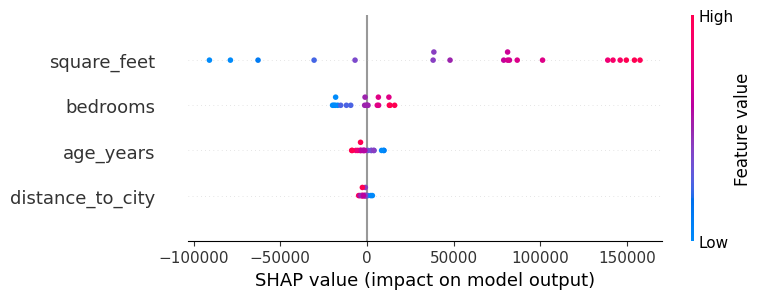

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import shap

# Summary Plot
shap.summary_plot(shap_values_rf, X_test)
plt.gcf().suptitle("SHAP Summary Plot — Feature Importance", y=1.02)
plt.tight_layout()
plt.show()

### Key SHAP Explainers

| Explainer | Use Case | Speed | Accuracy |
|-----------|----------|-------|----------|
| `LinearExplainer` | Linear models | Fast | Exact |
| `TreeExplainer` | Tree-based models (RF, XGBoost, LightGBM) | Fast | Exact |
| `DeepExplainer` | Neural networks (TensorFlow, PyTorch) | Medium | Approximate |
| `KernelExplainer` | Any model (model-agnostic) | Slow | Approximate |
| `Explainer` | Auto-detects best explainer | Varies | Varies |

### Benefits of SHAP

1. **Theoretically Grounded**: Based on Shapley values from game theory
2. **Consistent**: Higher SHAP value always means greater impact
3. **Local & Global**: Explains individual predictions and overall model behavior
4. **Model-Agnostic**: Works with any ML model (with appropriate explainer)
5. **Additive**: SHAP values sum to prediction - base_value

## Advanced Topics

### 1. Computational Complexity

**Problem**: Computing exact Shapley values requires evaluating 2ⁿ coalitions!

**Time Complexity**: O(2ⁿ × n) where n is the number of players

**Solutions**:
- **Sampling**: Approximate by sampling random coalitions
- **Polynomial Games**: For certain games, closed-form solutions exist
- **Tree SHAP**: Efficient algorithm for tree-based models

### 2. Approximation via Sampling

```python
import random

def approximate_shapley(
    player: Any,
    players: Set[Any],
    value_func: Callable[[Set[Any]], float],
    n_samples: int = 1000
) -> float:
    """
    Approximate Shapley value using Monte Carlo sampling.
    
    Args:
        player: Player to calculate value for
        players: All players
        value_func: Value function
        n_samples: Number of random permutations to sample
    
    Returns:
        Approximate Shapley value
    """
    marginal_contributions = []
    players_list = list(players)
    
    for _ in range(n_samples):
        # Random permutation of players
        random.shuffle(players_list)
        
        # Find where our player appears
        player_idx = players_list.index(player)
        
        # Coalition = all players before this one
        coalition = set(players_list[:player_idx])
        
        # Marginal contribution
        with_player = value_func(coalition | {player})
        without_player = value_func(coalition)
        mc = with_player - without_player
        
        marginal_contributions.append(mc)
    
    # Average is the Shapley value
    return sum(marginal_contributions) / len(marginal_contributions)
```

### 3. Key Insights

**When to use Shapley Values:**
- ✅ Fair allocation problems
- ✅ Feature importance in ML
- ✅ Data valuation
- ✅ Explaining black-box models

**Limitations:**
- ❌ Computationally expensive for many players
- ❌ Assumes all coalitions are equally likely
- ❌ May not match human intuition in all cases

## Summary

**Shapley Values** provide a theoretically sound way to measure individual contributions in collaborative settings. Key takeaways:

1. **Fair Distribution**: Satisfies important fairness axioms
2. **General Purpose**: Applicable beyond game theory
3. **ML Explainability**: Foundation of SHAP values
4. **Computationally Intensive**: Requires approximations for large problems

### Libraries

- **SHAP**: Efficient Shapley value computation for ML models
- **Fairlearn**: ML fairness tools including Shapley-based methods
- **PySHAP**: Python implementation for various use cases